In [1]:
!pip install --quiet gensim

In [2]:
!pip install focal-loss

In [3]:
# Imports
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, TimeDistributed, Dense, Dropout, Masking
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from focal_loss import SparseCategoricalFocalLoss
import tensorflow as tf
from tensorflow.keras import backend as K

from gensim.models import Word2Vec

In [4]:
df = pd.read_csv("/content/ner_dataset.csv", encoding="latin1")

In [5]:
print(df.head())

    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1          NaN             of   IN   O
2          NaN  demonstrators  NNS   O
3          NaN           have  VBP   O
4          NaN        marched  VBN   O


In [6]:
# Tag statistics
tag_counts = df["Tag"].value_counts()
tag_pcts = (df["Tag"].value_counts(normalize=True) * 100).round(2)

print(f"n Total Unique NER Tags: {df['Tag'].nunique()}")
print(f"\n Tag Distribution:\n")

tag_summary = pd.DataFrame({
    'Count': tag_counts,
    'Percentage': tag_pcts
})
print(tag_summary)

n Total Unique NER Tags: 17

 Tag Distribution:

        Count  Percentage
Tag                      
O      887908       84.68
B-geo   37644        3.59
B-tim   20333        1.94
B-org   20143        1.92
I-per   17251        1.65
B-per   16990        1.62
I-org   16784        1.60
B-gpe   15870        1.51
I-geo    7414        0.71
I-tim    6528        0.62
B-art     402        0.04
B-eve     308        0.03
I-art     297        0.03
I-eve     253        0.02
B-nat     201        0.02
I-gpe     198        0.02
I-nat      51        0.00


In [7]:
# Entity type analysis (B- and I- prefixes)
entity_types = {}
for tag in df['Tag'].unique():
    if tag != 'O':
        entity_type = tag.split('-')[1] if '-' in tag else tag
        entity_types[entity_type] = entity_types.get(entity_type, 0) + len(df[df['Tag'] == tag])

print(f"Entity Types Distribution:")
for entity, count in sorted(entity_types.items(), key=lambda x: x[1], reverse=True):
    print(f"   {entity}: {count:,} tokens ({count/len(df)*100:.2f}%)")

Entity Types Distribution:
   geo: 45,058 tokens (4.30%)
   org: 36,927 tokens (3.52%)
   per: 34,241 tokens (3.27%)
   tim: 26,861 tokens (2.56%)
   gpe: 16,068 tokens (1.53%)
   art: 699 tokens (0.07%)
   eve: 561 tokens (0.05%)
   nat: 252 tokens (0.02%)


In [8]:
print("MISSING DATA ANALYSIS")
print("-"*50)

missing_data = df.isnull().sum()
missing_pct = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_pct
})
print("\n", missing_df)

MISSING DATA ANALYSIS
--------------------------------------------------

             Missing Count  Percentage
Sentence #        1000616   95.426269
Word                   10    0.000954
POS                     0    0.000000
Tag                     0    0.000000


# **Preprocessing**

In [9]:
# Handle missing Sentence # values
df["Sentence #"] = df["Sentence #"].ffill()

In [10]:
# Fill missing words
df["Word"] = df["Word"].fillna("")

In [11]:
def clean_word(w):
    if not isinstance(w, str):
        return ""
    w = w.strip()
    w = w.lower()
    w = re.sub(r"[^a-z0-9\-\_]", "", w)
    return w

In [12]:
df["Word"] = df["Word"].apply(clean_word)
df["POS"] = df["POS"].astype(str)
df["Tag"] = df["Tag"].astype(str)

In [13]:
"""# **Group sentences**"""

def get_sentences(df):
    sentences = []
    grouped = df.groupby("Sentence #")
    for _, group in grouped:
        sentence = [(row["Word"], row["POS"], row["Tag"]) for _, row in group.iterrows()]
        sentences.append(sentence)
    return sentences

sentences = get_sentences(df)
print("Number of sentences:", len(sentences))
print("Example sentence (first):", sentences[0][:10])

Number of sentences: 47959
Example sentence (first): [('thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('london', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O')]


# **Word2Vec Feature extraction**

In [14]:
# Prepare words list for embeddings (list of list of words)
sentences_words = [[w for (w,p,t) in s] for s in sentences]
all_words = [w for sent in sentences_words for w in sent]
vocab = Counter(all_words)
print("Vocabulary size (raw tokens):", len(vocab))

Vocabulary size (raw tokens): 31501


In [15]:
"""# **Train Word2Vec on dataset**"""

# Word2Vec params - you can tune these
EMBED_DIM = 100
W2V_MIN_COUNT = 1   # 1 -> keep all words (set higher to ignore very rare words)
W2V_WINDOW = 5
W2V_WORKERS = 4
W2V_EPOCHS = 10

In [16]:
# Train Word2Vec on sentences_words
w2v_model = Word2Vec(
    sentences=sentences_words,
    vector_size=EMBED_DIM,
    window=W2V_WINDOW,
    min_count=W2V_MIN_COUNT,
    workers=W2V_WORKERS,
    epochs=W2V_EPOCHS,
    sg=1  # skip-gram; set sg=0 for CBOW if you prefer
)

In [17]:
# Build KeyedVectors only for memory efficiency:
w2v_kv = w2v_model.wv
print("Word2Vec vocab size:", len(w2v_kv.index_to_key))

Word2Vec vocab size: 31501


In [18]:
# Function to get vector for a word (handles OOV -> zero vector)
def get_w2v_vector(word, kv, dim=EMBED_DIM):
    w = str(word).lower()
    if w in kv:
        return kv[w]
    else:
        return np.zeros(dim, dtype='float32')

In [19]:
"""Create X (vectors) and y (tags)"""

# FEATURE EXTRACTION USING WORD2VEC
X = []
y = []

for sent in sentences:
    words = [w for (w,p,t) in sent]
    tags  = [t for (w,p,t) in sent]
    vectors = [get_w2v_vector(w, w2v_kv, EMBED_DIM) for w in words]
    X.append(vectors)
    y.append(tags)

In [20]:
# Padding
MAX_LEN = max(len(s) for s in X)
VEC_DIM = EMBED_DIM
print("MAX_LEN (longest sentence):", MAX_LEN)

def pad_X(X, maxlen, vec_dim):
    X_pad = np.zeros((len(X), maxlen, vec_dim), dtype="float32")
    for i, sent in enumerate(X):
        length = min(len(sent), maxlen)
        X_pad[i, :length, :] = np.array(sent[:length])
    return X_pad

X_padded = pad_X(X, MAX_LEN, VEC_DIM)
print("X_padded shape:", X_padded.shape)

MAX_LEN (longest sentence): 104
X_padded shape: (47959, 104, 100)


In [21]:
# Encode tags
all_tags = sorted(list(set(tag for sent in y for tag in sent)))
tag_encoder = LabelEncoder()
tag_encoder.fit(all_tags)
num_tags = len(all_tags)
print("Num tags:", num_tags)

y_encoded = [tag_encoder.transform(sent) for sent in y]
pad_tag = tag_encoder.transform(["O"])[0] if "O" in tag_encoder.classes_ else 0
y_padded = pad_sequences(y_encoded, maxlen=MAX_LEN, padding="post", value=pad_tag)
y_categorical = to_categorical(y_padded, num_classes=num_tags)
print("y_categorical shape:", y_categorical.shape)

Num tags: 17
y_categorical shape: (47959, 104, 17)


# **BiLSTM Model**

In [22]:
# MODEL CONFIG
LSTM_UNITS = 128
DROPOUT_RATE = 0.3
BATCH_SIZE = 32
EPOCHS = 5

model = Sequential()
# Mask padding vectors (0s)
model.add(Masking(mask_value=0.0, input_shape=(MAX_LEN, VEC_DIM)))
# BiLSTM layer
model.add(Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)))
# Dropout
model.add(Dropout(DROPOUT_RATE))
# TimeDistributed dense layer for token classification
model.add(TimeDistributed(Dense(num_tags, activation="softmax")))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss for multi-class classification (supports sequence labeling)
    y_true: one-hot → shape = (batch, seq, classes)
    y_pred: softmax --> same shape
    """
    def loss(y_true, y_pred):
        # clip to prevent NaN
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)

        cross_entropy = -y_true * K.log(y_pred)
        focal = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        return K.sum(focal, axis=-1)  # sum on classes → per token

    return loss

In [ ]:
model.compile(
    optimizer="adam",
    loss=categorical_focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 104, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 104, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 104, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 104, 17)        │         4,369 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,865 (933.07 KB)

 Trainable params: 238,865 (933.07 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X_padded, y_categorical, test_size=0.1, random_state=42)

In [29]:
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Train shape: (43163, 104, 100)
Validation shape: (4796, 104, 100)


In [30]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

Epoch 1/5
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 662s 483ms/step - accuracy: 0.9726 - loss: 0.0715 - val_accuracy: 0.9878 - val_loss: 0.0263
Epoch 2/5
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 713s 506ms/step - accuracy: 0.9876 - loss: 0.0263 - val_accuracy: 0.9894 - val_loss: 0.0219
Epoch 3/5
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 709s 482ms/step - accuracy: 0.9890 - loss: 0.0220 - val_accuracy: 0.9901 - val_loss: 0.0200
Epoch 4/5
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 675s 477ms/step - accuracy: 0.9898 - loss: 0.0197 - val_accuracy: 0.9907 - val_loss: 0.0186
Epoch 5/5
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 630s 467ms/step - accuracy: 0.9902 - loss: 0.0186 - val_accuracy: 0.9908 - val_loss: 0.0178


In [31]:
# Quick sample prediction (same index as before)
sample = X_padded[10:11]
pred = model.predict(sample)

pred_tags = np.argmax(pred, axis=-1)[0]
true_tags = np.argmax(y_categorical[10], axis=-1)

decoded_pred = tag_encoder.inverse_transform(pred_tags)
decoded_true = tag_encoder.inverse_transform(true_tags)

print("Pred:", decoded_pred[:20])
print("True:", decoded_true[:20])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Pred: ['O' 'B-geo' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'B-org'
 'I-org' 'O' 'O' 'B-geo' 'I-geo']
True: ['O' 'B-geo' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'B-org'
 'I-org' 'O' 'O' 'B-geo' 'I-geo']


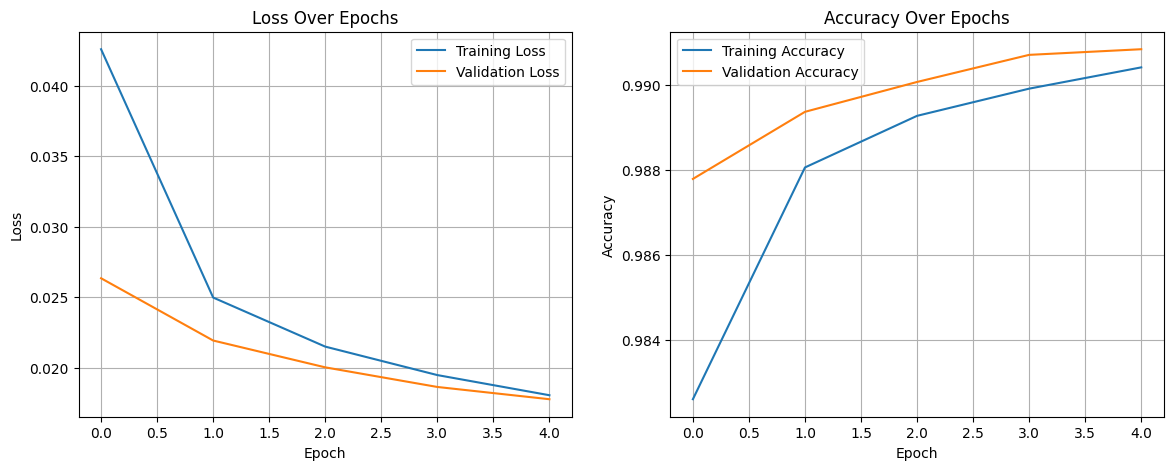

In [32]:
"""Training visualization"""

def plot_training(history):
    plt.figure(figsize=(14, 5))

    # LOSS
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # ACCURACY
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_training(history)

Get predictions on validation set and evaluate

In [33]:
y_val_pred = model.predict(X_val)
y_val_pred_ids = np.argmax(y_val_pred, axis=-1)
y_val_true_ids = np.argmax(y_val, axis=-1)

# Convert IDs back to tag labels
y_val_pred_labels = [tag_encoder.inverse_transform(seq) for seq in y_val_pred_ids]
y_val_true_labels = [tag_encoder.inverse_transform(seq) for seq in y_val_true_ids]

# Flatten predictions (remove padding tokens)
true_tags_flat = []
pred_tags_flat = []

for t_seq, p_seq, x_seq in zip(y_val_true_ids, y_val_pred_ids, X_val):
    real_len = np.count_nonzero(np.sum(x_seq, axis=1))  # non-zero vectors
    true_tags_flat.extend(tag_encoder.inverse_transform(t_seq[:real_len]))
    pred_tags_flat.extend(tag_encoder.inverse_transform(p_seq[:real_len]))

print("===== CLASSIFICATION REPORT =====\n")
print(classification_report(true_tags_flat, pred_tags_flat))

150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step
===== CLASSIFICATION REPORT =====



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        46
       B-eve       0.46      0.17      0.25        35
       B-geo       0.82      0.89      0.85      3797
       B-gpe       0.94      0.90      0.92      1592
       B-nat       0.60      0.15      0.24        20
       B-org       0.78      0.51      0.62      2055
       B-per       0.81      0.79      0.80      1668
       B-tim       0.92      0.84      0.88      2033
       I-art       0.00      0.00      0.00        40
       I-eve       0.67      0.15      0.25        39
       I-geo       0.83      0.69      0.75       713
       I-gpe       1.00      0.19      0.32        16
       I-nat       0.00      0.00      0.00         7
       I-org       0.75      0.53      0.62      1699
       I-per       0.84      0.87      0.85      1658
       I-tim       0.79      0.73      0.76       585
           O       0.98      0.99      0.98     88532

    accuracy              

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


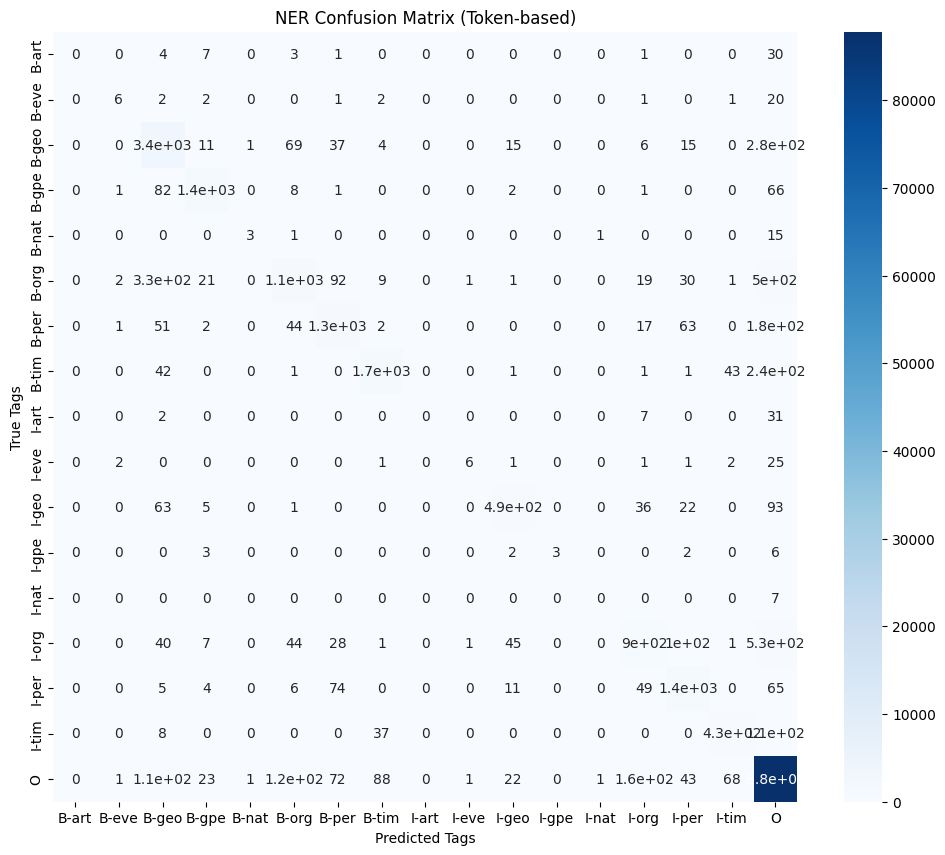

In [34]:
tags = list(tag_encoder.classes_)
cm = confusion_matrix(true_tags_flat, pred_tags_flat, labels=tags)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=tags, yticklabels=tags)
plt.title("NER Confusion Matrix (Token-based)")
plt.xlabel("Predicted Tags")
plt.ylabel("True Tags")
plt.show()

In [35]:
"""Predict on a new sentence (using Word2Vec)"""

def preprocess_sentence(sentence):
    # clean + tokenize (simple)
    words = [clean_word(w) for w in sentence.lower().split()]
    # remove possible empty tokens
    return [w for w in words if w != ""]

def sentence_to_w2v(sentence_words, kv, dim=EMBED_DIM):
    vectors = [get_w2v_vector(w, kv, dim) for w in sentence_words]
    padded = np.zeros((1, MAX_LEN, dim), dtype="float32")
    length = min(len(vectors), MAX_LEN)
    padded[0, :length, :] = np.array(vectors[:length])
    return padded, length

def decode_predictions(pred_ids, length):
    pred_ids = pred_ids[:length]
    pred_tags = tag_encoder.inverse_transform(pred_ids)
    return pred_tags

def extract_entities(words, tags):
    entities = []
    current_ent = None
    current_type = None
    for w, t in zip(words, tags):
        if t.startswith("B-"):
            if current_ent:
                entities.append((current_type, " ".join(current_ent)))
            current_type = t.split("-")[1]
            current_ent = [w]
        elif t.startswith("I-") and current_ent and t.split("-")[1] == current_type:
            current_ent.append(w)
        else:
            if current_ent:
                entities.append((current_type, " ".join(current_ent)))
                current_ent = None
                current_type = None
    if current_ent:
        entities.append((current_type, " ".join(current_ent)))
    return entities

def predict_sentence(sentence):
    words = preprocess_sentence(sentence)
    x_vec, real_len = sentence_to_w2v(words, w2v_kv, EMBED_DIM)
    pred = model.predict(x_vec)
    pred_ids = np.argmax(pred, axis=-1)[0]
    tags = decode_predictions(pred_ids, real_len)

    print("\n=== TOKEN TAGS ===")
    for w, t in zip(words, tags):
        print(f"{w:15} → {t}")

    entities = extract_entities(words, tags)
    print("\n=== EXTRACTED ENTITIES ===")
    if not entities:
        print("No entities found.")
    else:
        for ent_type, ent_val in entities:
            print(f"{ent_type:5} → {ent_val}")
    return tags, entities

# TEST
predict_sentence("Barack Obama visited Paris last week.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

=== TOKEN TAGS ===
barack          → B-per
obama           → I-per
visited         → O
paris           → B-geo
last            → O
week            → O

=== EXTRACTED ENTITIES ===
per   → barack obama
geo   → paris


(array(['B-per', 'I-per', 'O', 'B-geo', 'O', 'O'], dtype='<U5'),
 [('per', 'barack obama'), ('geo', 'paris')])

In [36]:
model.save("model.h5")

In [37]:
import pickle

with open("tag_encoder.pkl", "wb") as f:
    pickle.dump(tag_encoder, f)

In [38]:
w2v_model.save("word2vec.model")